## Installing and Importing libraries

In [1]:
!pip install -q tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 616 kB 30.5 MB/s 
     |████████████████████████████████| 1.2 MB 30.7 MB/s 
     |████████████████████████████████| 596 kB 66.1 MB/s 
     |████████████████████████████████| 840 kB 75.4 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 6.4 MB 57.0 MB/s 
     |████████████████████████████████| 87 kB 7.4 MB/s 
     |████████████████████████████████| 3.4 MB 64.6 MB/s 
     |████████████████████████████████| 1.1 MB 61.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.0 MB/s 
     |████████████████████████████████| 234 kB 72.2 MB/s 
     |████████████████████████████████| 120 kB 73.0 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 352 kB 53.4 MB/s 
     |████████████████████████████████| 47.7 MB 80 kB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |████████████████████████████████| 462 kB 58.6 MB/s 
     |██████████████

In [2]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
import tflite_model_maker.image_classifier 
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time 

## Importing the dataset 

In [3]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [4]:
!kaggle datasets download -d rahilmehtaucoe2784/cloth-pattern

100% 2.48G/2.48G [01:35<00:00, 51.0MB/s]
100% 2.48G/2.48G [01:35<00:00, 27.8MB/s]


In [5]:
%%capture
!unzip \*.zip && rm *.zip &> /dev/null

## jpeg


In [13]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
               raise TypeError("issue reading jpeg file")           


bads = []

image_path = '/content/NEW LARGE IMAGE /paisley pattern'
for dirName, subdirList, fileList in os.walk(image_path):
    imagesList = fileList
    for img in tqdm(imagesList):
      image = os.path.join(image_path,img)
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)

print(bads)
for name in bads:
  os.remove(os.path.join(image_path,name))
  print("removed")


100%|██████████| 1053/1053 [00:00<00:00, 11206.58it/s]

['paisley 1098.jpeg', 'paisley 1102.jpeg', 'paisley 1096.jpeg', 'paisley 1080.jpeg', 'paisley 1076.jpeg', 'paisley 1074.jpeg', 'paisley 1092.jpeg', 'paisley 1088.jpeg', 'paisley 1090.jpeg', 'paisley 1082.jpeg', 'paisley 1106.jpeg', 'paisley 1084.jpeg', 'paisley 1078.jpeg', 'paisley 1094.jpeg', 'paisley 1100.jpeg']
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed


## Train


In [9]:
image_path = "/content/NEW LARGE IMAGE "
test_image_path = "/content/test"
data = ImageClassifierDataLoader.from_folder(image_path)
total_test_data = ImageClassifierDataLoader.from_folder(test_image_path)

INFO:tensorflow:Load image with size: 4710, num_label: 7, labels: checkered, dots, florals , horizontal strip, paisley pattern, vertical strip, zig zag .
INFO:tensorflow:Load image with size: 6706, num_label: 7, labels: checkered, dot , florals, horizonal strip, paisley pattern, vertical strip, zig zag.


In [10]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

In [11]:
print(f"total imagees in Train data is : {len(train_data)}")
print(f"total imagees in Validate data is : {len(validation_data)}")
print(f"total imagees in Test data is : {len(total_test_data)}")

total imagees in Train data is : 3768
total imagees in Validate data is : 471
total imagees in Test data is : 6706


In [12]:
model = image_classifier.create(train_data, 
                                model_spec= tflite_model_maker.image_classifier.MobileNetV2Spec(), 
                                epochs = 5,
                                batch_size = 64,
                                validation_data = validation_data,
                                )

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             2257984   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


51/58 [=========================>....] - ETA: 18s - loss: 1.1838 - accuracy: 0.6860

InvalidArgumentError: ignored

## Evaluation 

In [ ]:
start = time.time()
loss, accuracy = model.evaluate(test_data)
end = time.time()

15/15 [==============================] - 50s 1s/step - loss: 0.6776 - accuracy: 0.9298


In [ ]:
print(f"The time taken to evaluation is :{end-start} and with {accuracy*100}% accuracy")

The time of execution of evaluation is  : 49.834147214889526


### Visuallising the test sample 

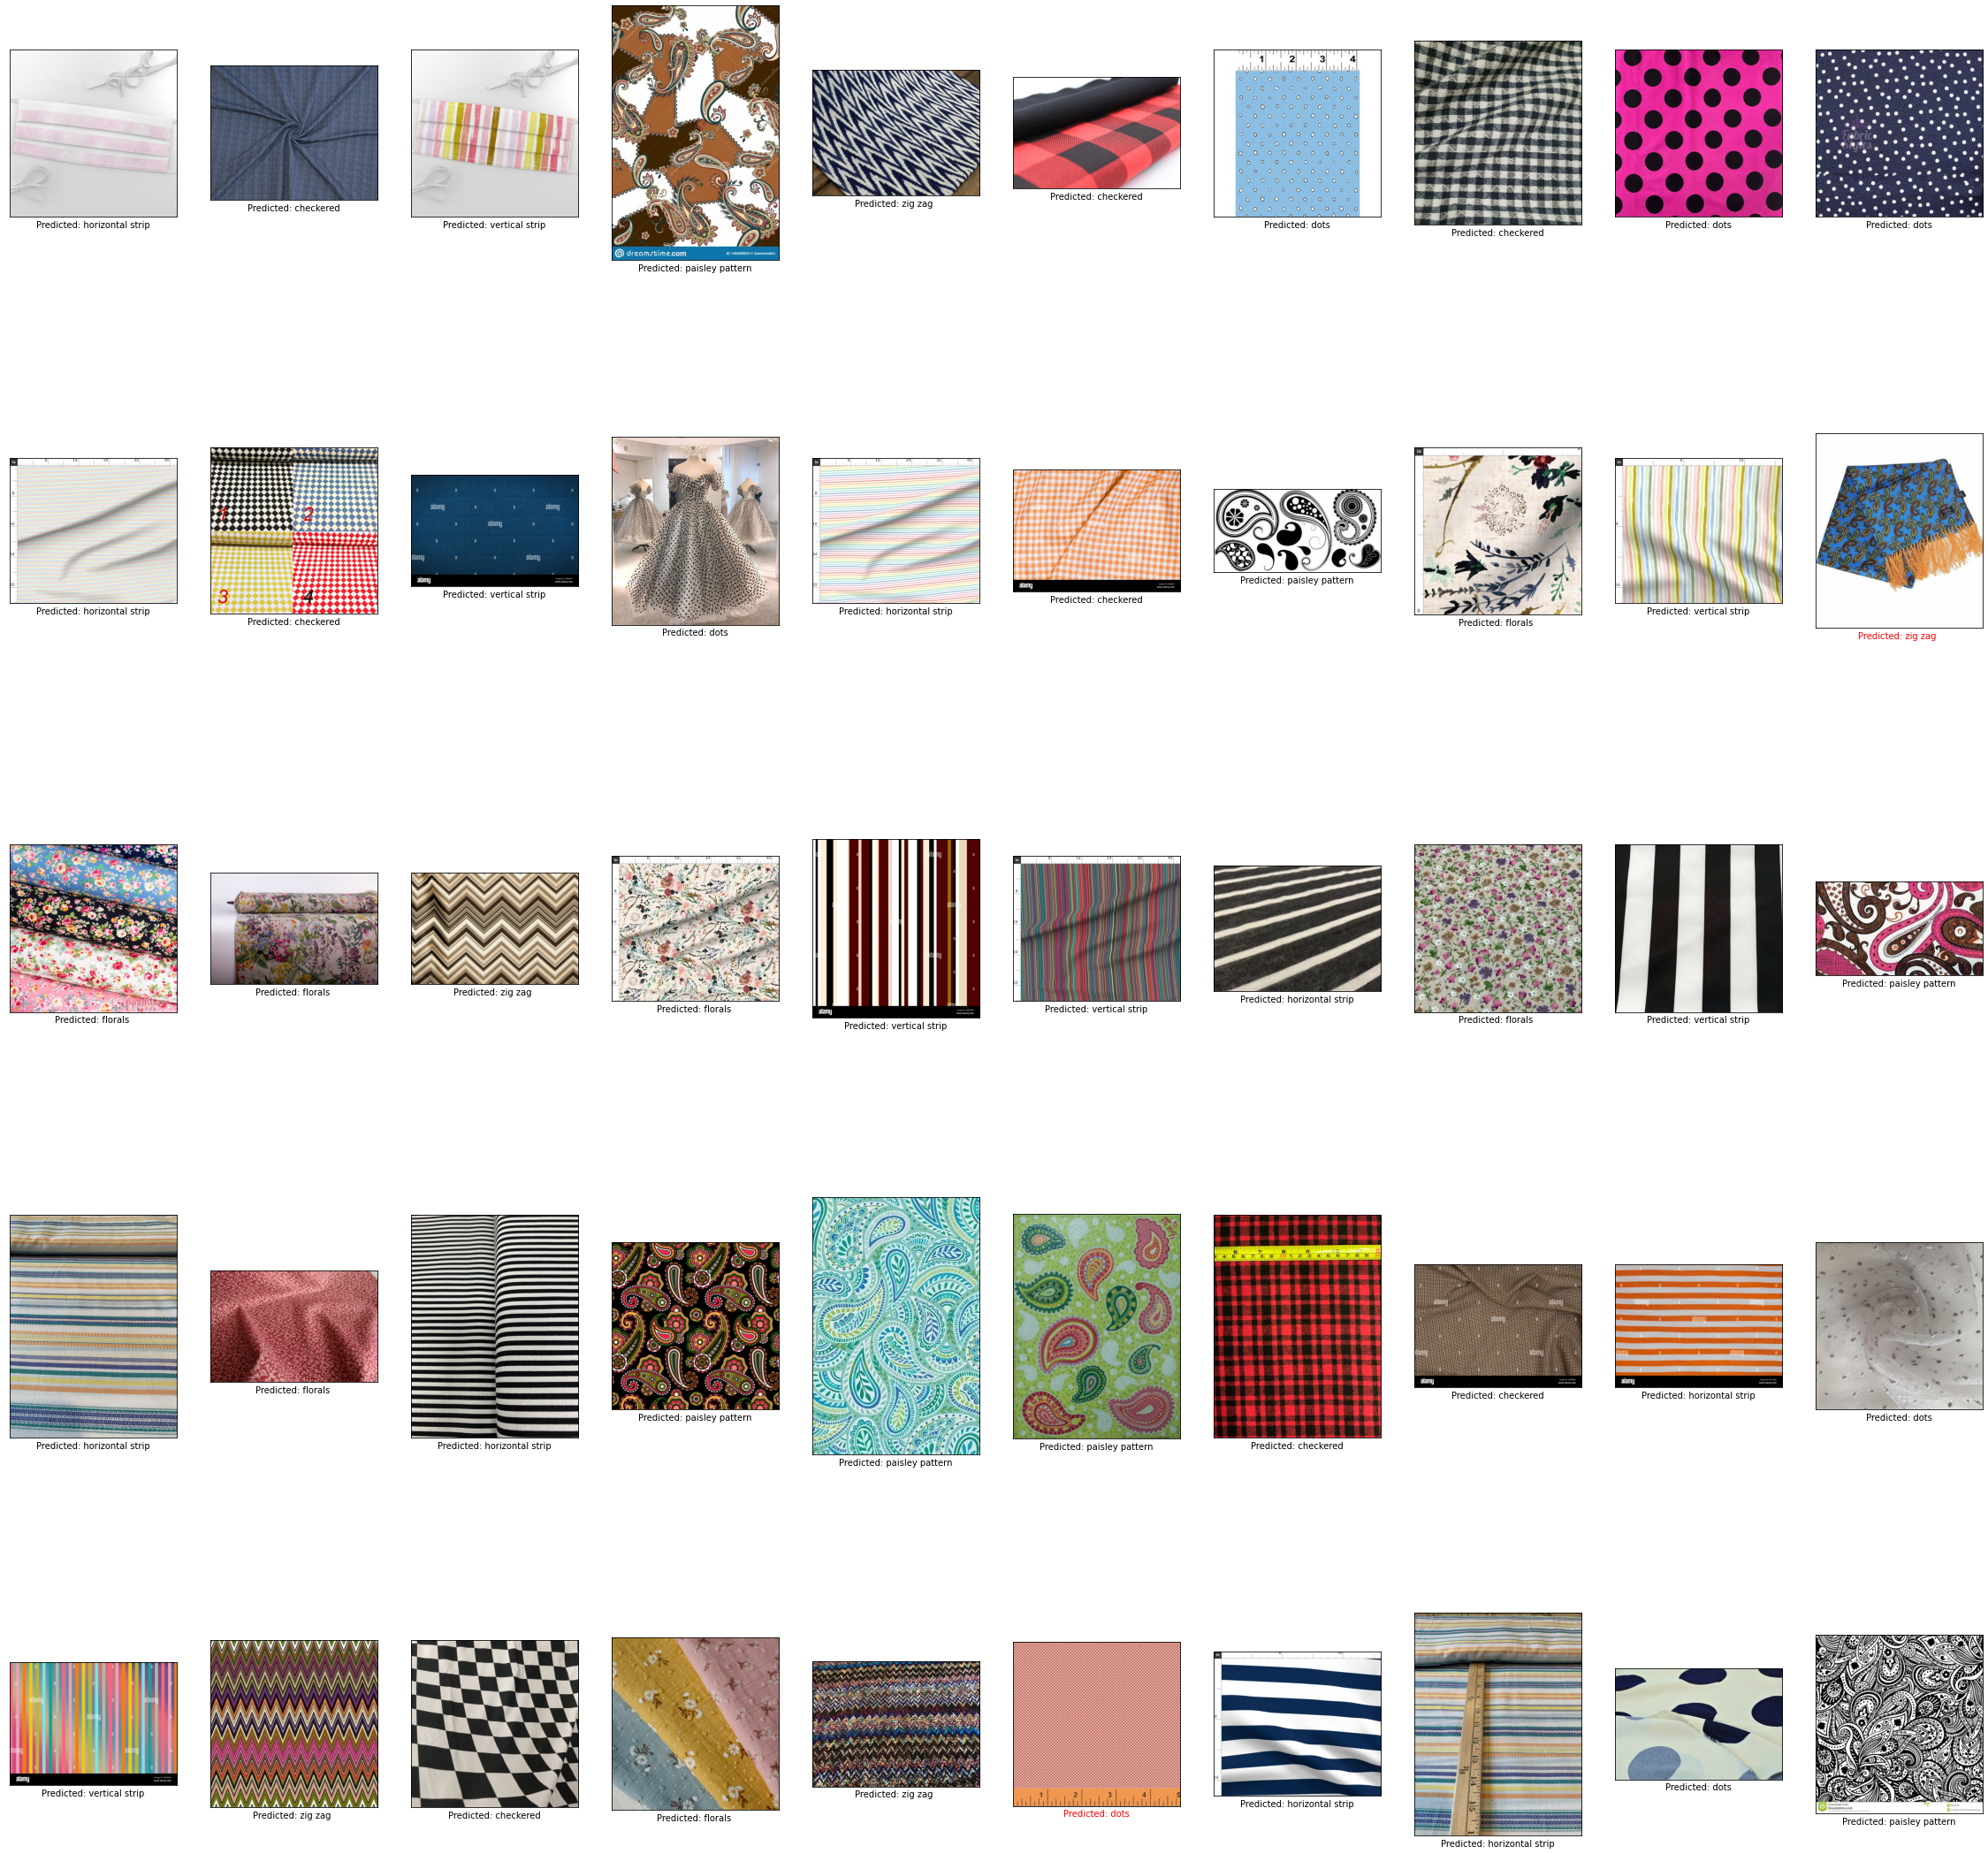

In [ ]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(40, 40))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(50)):
  ax = plt.subplot(5, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

## Saving the model 

In [ ]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: /tmp/tmp1r48s14n/assets


INFO:tensorflow:Assets written to: /tmp/tmp1r48s14n/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp55_km151/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp55_km151/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


In [ ]:
from tflite_model_maker.config import ExportFormat

In [ ]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt
